# Requirements

In [1]:
!pip install --upgrade kaggle

Requirement already up-to-date: kaggle in /usr/local/lib/python3.7/dist-packages (1.5.12)


In [2]:
from google.colab import files
!mkdir -p ~/.kaggle
uploaded = files.upload()
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d kasikrit/att-database-of-faces

Saving kaggle.json to kaggle.json
  0% 0.00/3.61M [00:00<?, ?B/s]
100% 3.61M/3.61M [00:00<00:00, 58.8MB/s]


In [ ]:
!unzip att-database-of-faces.zip -d dataset

# Data

In [4]:
import PIL
import glob

import matplotlib.pyplot as plt

In [5]:
def plot_faces(sample='s1'):
  faces = glob.glob(f'dataset/{sample}/*.pgm')
  w, n = 4, len(faces)
  fig, ax = plt.subplots(n//w+1, w, figsize=(6, 8))
  for i, f in enumerate(faces):
    img = PIL.Image.open(f)
    ax[i//w, i%4].imshow(img, cmap='gray')
    ax[i//w, i%4].set_axis_off()
  for j in range(n%w, w):
    ax[i//w, j].set_axis_off()
  plt.tight_layout()

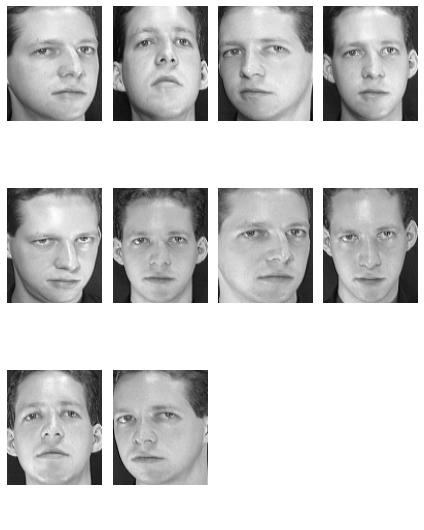

In [6]:
plot_faces('s1')

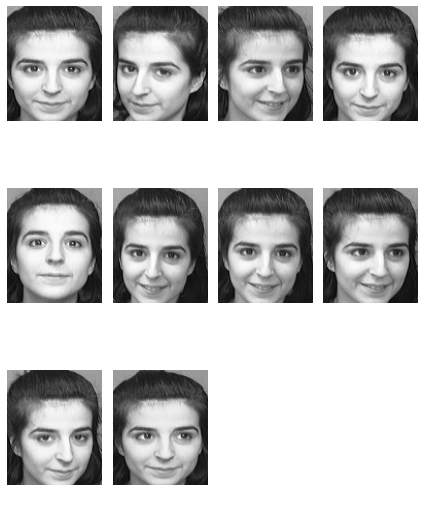

In [7]:
plot_faces('s10')

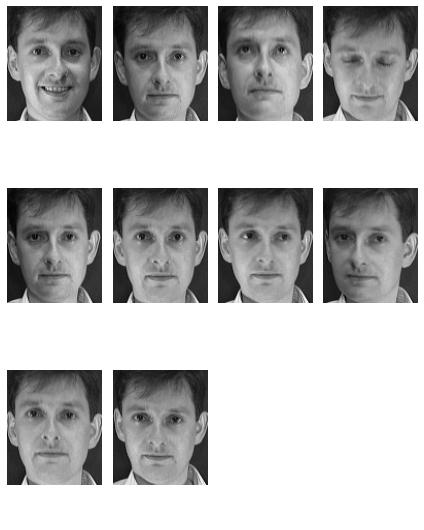

In [8]:
plot_faces('s24')

In [9]:
!find dataset -type d | wc -l
!find dataset -type f | wc -l

41
401


In [10]:
import os
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader

In [11]:
class FacesDataset(Dataset):
  def __init__(self, data_dir='dataset'):
    self.dir = data_dir

  def __getitem__(self, index):
    img1_dir = np.random.choice(40)+1
    img1_file = np.random.choice(10)+1
    img1 = PIL.Image.open(f'{self.dir}/s{img1_dir}/{img1_file}.pgm')
    p = np.random.rand()
    if p < 0.5:
      img2_dir = img1_dir
      target = 0
    else:
      img2_dir = np.random.choice(40)+1
      target = 1
    img2_file = np.random.choice(10)+1
    img2 = PIL.Image.open(f'{self.dir}/s{img2_dir}/{img2_file}.pgm')
    img1 = torch.from_numpy(np.array(img1, np.int32, copy=False))
    img2 = torch.from_numpy(np.array(img2, np.int32, copy=False))
    target = torch.from_numpy(np.array([target])).to(dtype=torch.float32)
    return img1, img2, target

  def __len__(self):
    return 10000

dataset = FacesDataset()

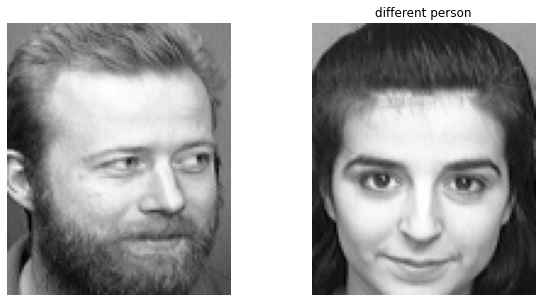

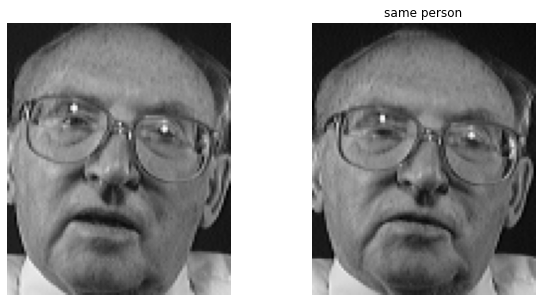

In [12]:
def next_sample(d):
  im1, im2, target = next(d)
  target = 'different person' if target.item() else 'same person'
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  ax[0].imshow(im1.detach().numpy().reshape(112, 92), cmap='gray')
  ax[1].imshow(im2.detach().numpy().reshape(112, 92), cmap='gray')
  ax[0].set_axis_off()
  ax[1].set_axis_off()
  plt.title(target);
  
  
train_dataloader = DataLoader(dataset, num_workers=1, batch_size=1, shuffle=True)
d = iter(train_dataloader)

next_sample(d)
next_sample(d)

# Siamese Network

In [13]:
import torch.nn as nn
from torchvision.models import resnet18

In [14]:
class SiameseNetwork(nn.Module):
  def __init__(self):
    super(SiameseNetwork, self).__init__()
    self.backbone = resnet18(pretrained=True)

  def forward(self, x):
    return self.backbone(x)

# Training

In [15]:
from tqdm import tqdm
import torchvision
import torch.nn.functional as F

In [16]:
def criterion(output1, output2, label, margin=2):
  """
  Contrastive loss function based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
  """
  euclidean_distance = F.pairwise_distance(output1, output2)
  loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2)
                                + (label) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
  return loss_contrastive

In [23]:
train_dataloader = DataLoader(dataset,num_workers=1,batch_size=1,shuffle=True)
d = iter(train_dataloader)
network = SiameseNetwork().cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

losses = []
for epoch in tqdm(range(5)):
  epoch_loss = []
  for i in range(1000):
    img1, img2, target = next(d)
    img1 = img1.reshape(1, 1, 112, 92).expand(-1, 3, -1, -1).to(dtype=torch.float32).cuda()
    img2 = img2.reshape(1, 1, 112, 92).expand(-1, 3, -1, -1).to(dtype=torch.float32).cuda()
    output1 = network(img1)
    output2 = network(img2)
    optimizer.zero_grad()
    loss = criterion(output1, output2, target.cuda())
    loss.backward()
    optimizer.step()
    epoch_loss.append(loss.item())
  losses.append(np.mean(epoch_loss))

100%|██████████| 5/5 [01:45<00:00, 21.16s/it]


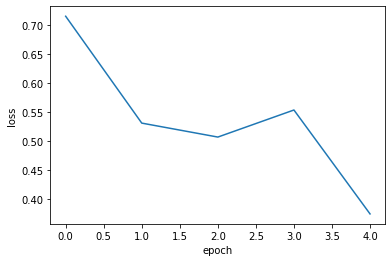

In [24]:
plt.plot(range(len(losses)), losses)
plt.xlabel('epoch')
plt.ylabel('loss');

In [25]:
def plot_sample(img1, img2, dissimilarity):
  fig, ax = plt.subplots(1, 2, figsize=(6, 3))
  ax[0].imshow(img1.detach().numpy().reshape(112, 92), cmap='gray')
  ax[1].imshow(img2.detach().numpy().reshape(112, 92), cmap='gray')
  ax[0].set_axis_off()
  ax[1].set_axis_off()
  plt.title(dissimilarity);

dataset = FacesDataset()
test_dataloader = DataLoader(dataset, num_workers=1, batch_size=1, shuffle=True)
d = iter(test_dataloader)
img1, _, label1 = next(d)
img1_exp = img1.reshape(1, 1, 112, 92).expand(-1, 3, -1, -1).to(dtype=torch.float32)

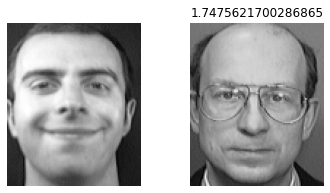

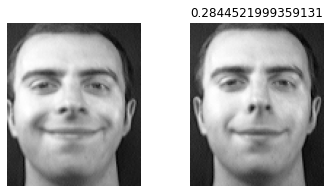

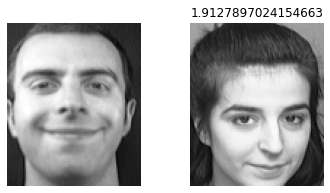

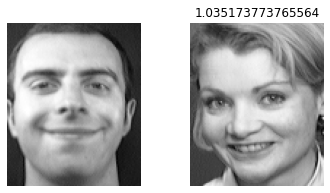

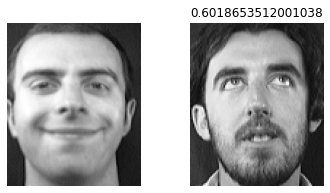

In [28]:
network = network.cpu()
for i in range(5):
    _, img2, label2 = next(d)
    img2_exp = img2.reshape(1, 1, 112, 92).expand(-1, 3, -1, -1).to(dtype=torch.float32)
    output1, output2 = network(img1_exp), network(img2_exp)
    euclidean_distance = F.pairwise_distance(output1, output2).detach().item()
    plot_sample(img1, img2, euclidean_distance)

lowest dissimilarity for the pair of images of the same person (second row) among the 5 pairs.